# Work In Progress Vortex Panel Code

This project aims to use a vortex panel method to estimate the lift generated by a 2D airfoil.

(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.04841963363389343),
 np.float64(0.08525600373884175))

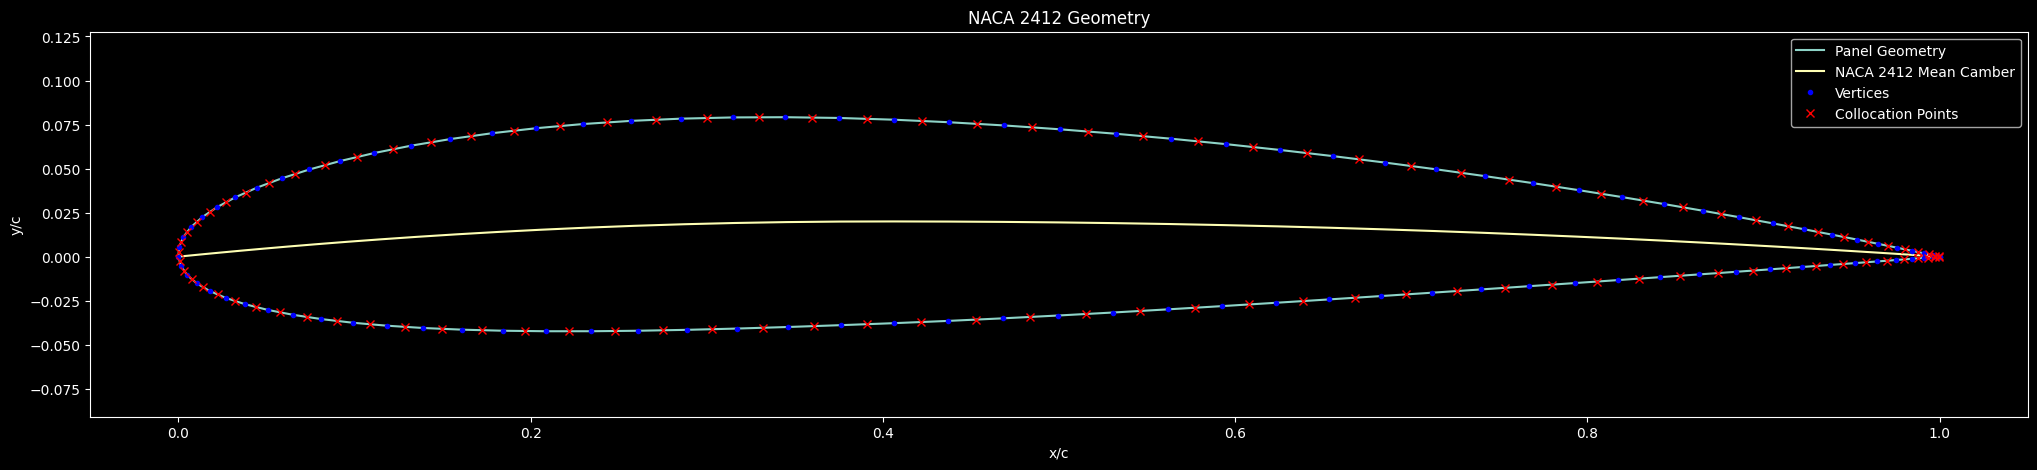

In [16]:
import numpy as np
import matplotlib.pyplot as plt

naca_4_digit_Airfoil = 2412 #User inputs
AOA = 10
U_freestream = 1
n = 100 #number of panels

#Parse naca 4 digit into geometry parameters
max_camber = np.floor(naca_4_digit_Airfoil/1000)
pos_max_camber = np.floor((naca_4_digit_Airfoil - (max_camber*1000))/100)
t2c = naca_4_digit_Airfoil - (max_camber*1000) - (pos_max_camber*100)
max_camber = max_camber / 100
pos_max_camber = pos_max_camber / 10
t2c = t2c / 100

#camber line
def camber_line_cord(max_camber, pos_max_camber, t2c,x):
    if x < pos_max_camber:
        yc = max_camber/pos_max_camber**2 * (2 * pos_max_camber * x - x ** 2)
        dyc_dx = (2 * max_camber / pos_max_camber**2) * (pos_max_camber - x)
    else:
        yc = max_camber/(1-pos_max_camber)**2 * (1-2*pos_max_camber + 2*pos_max_camber * x - x**2)
        dyc_dx = (2* max_camber / (1-pos_max_camber)**2)  * ( pos_max_camber - x)
    return [yc, dyc_dx]

#cosine spacing to better capture leading edge
beta = np.linspace(0, np.pi, int(n/2) + 1)
x = (1 - np.cos(beta)) / 2

yc = np.zeros(len(x))
dyc_dx = np.zeros(len(x))
for i in range(len(x)):
    yc[i] = camber_line_cord(max_camber, pos_max_camber, t2c,x[i])[0]
    dyc_dx[i] = camber_line_cord(max_camber, pos_max_camber, t2c,x[i])[1]
theta = np.arctan(dyc_dx)

#Thickness
yt = t2c * 5 * (0.2969 * np.sqrt(x) - .1260 * x - .3516 * x ** 2 + 0.2843 * x ** 3 - 0.1036 * x ** 4)   #using 0.1036 instead of 0.1015 to close trailing edge

xu = x - yt * np.sin(theta)  #upper cords
yu = yc + yt * np.cos(theta)
xl = x + yt * np.sin(theta) #lower cords
yl = yc - yt * np.cos(theta)


X_vort = np.concatenate((np.flip(xl)[0:-1], xu))  #combine upper and lower curves, order from lower TE to LE to upper TE
Y_vort = np.concatenate((np.flip(yl)[0:-1], yu))

#Create Collocation points
X_coll = np.zeros(len(X_vort) - 1)
Y_coll = np.zeros(len(X_vort) - 1)

for i in range(len(X_coll)):
    X_coll[i] = 0.5 * (X_vort[i] + X_vort[i + 1])
    Y_coll[i] = 0.5 * (Y_vort[i] + Y_vort[i+1])



plt.figure(figsize=(25, 5)) # Aspect ratio to see the curve better
plt.plot(X_vort, Y_vort, label='Panel Geometry')
plt.plot(x, yc, label=f'NACA {naca_4_digit_Airfoil} Mean Camber')
plt.plot(X_vort, Y_vort, 'bo', markersize=3, label='Vertices')
plt.plot(X_coll, Y_coll, 'rx', label='Collocation Points')
plt.legend()
plt.title(f"NACA {naca_4_digit_Airfoil} Geometry")
plt.xlabel("x/c")
plt.ylabel("y/c")
plt.axis('equal')


# Panel Method Theory
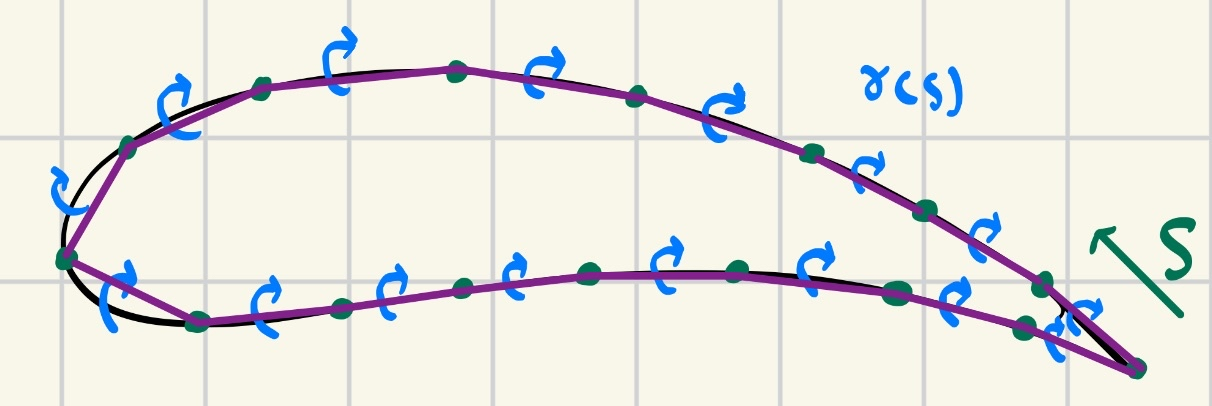

The Kutta-Joukowski Theorem (1) gives lift as a function of circulation across the airfoil. Equation (2) demonstrates that the total circulation $\Gamma$ can be broken up into local vortices $\gamma (s)$across the surface.As demonstrated above, the airfoil is broken up into smaller "panels" which are represented by the distance between two plotted points. Hence, the goal is to determine the local vortex strength across the surface of the airfoil. This is done using a zero penetration boundary condition on the surface of the airfoil, meaning the normal component of the velocity at the surface is 0. The normal velocity at the surface has two components as illustrated in (3), a free stream component $V_\infty,n$ and a component induced by the vortex panel $V_n$. Expanded out, (3) becomes (4) which is the fundamental equation for the vortex panel method.
$$ L = \rho V \Gamma \tag{1} $$
$$ \Gamma = \int_{a}^{b} \gamma ds \tag{2}$$
$$ V_{\infty,n} + V_n = 0\tag{3}$$
$$ V_\infty cos(\beta_i) - \sum_{j=1}^{n} \frac {\gamma_j} {2\pi} \int_{j} \frac {\partial \theta_{ij}} {\partial n_i} = 0 \tag{4}$$
$$ A\gamma + V_{\infty, n} = 0$$
$$ A\gamma = -V_{\infty, n}$$
$$ \Gamma = \sum \gamma $$


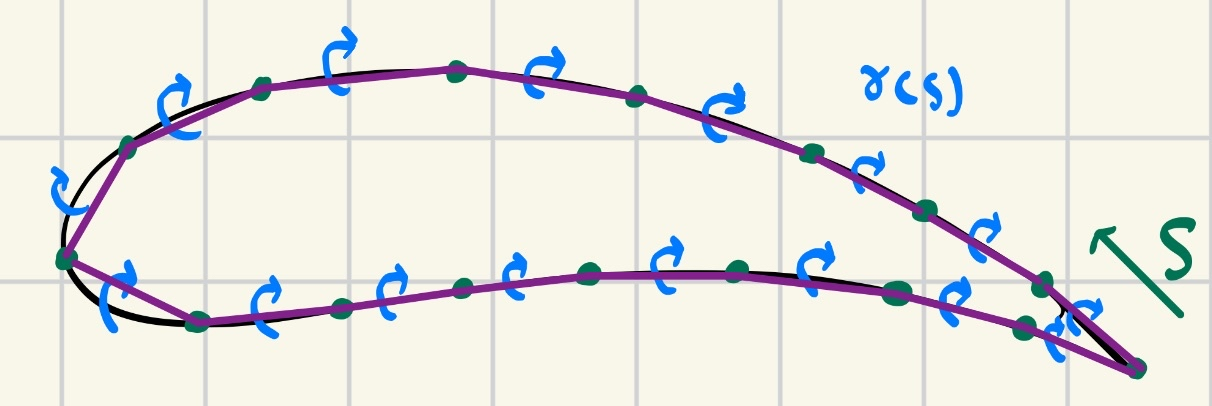
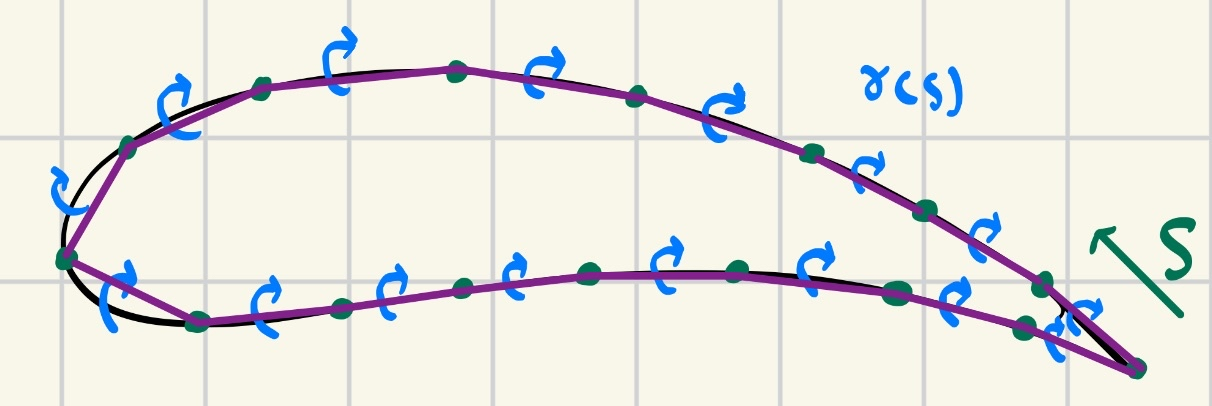
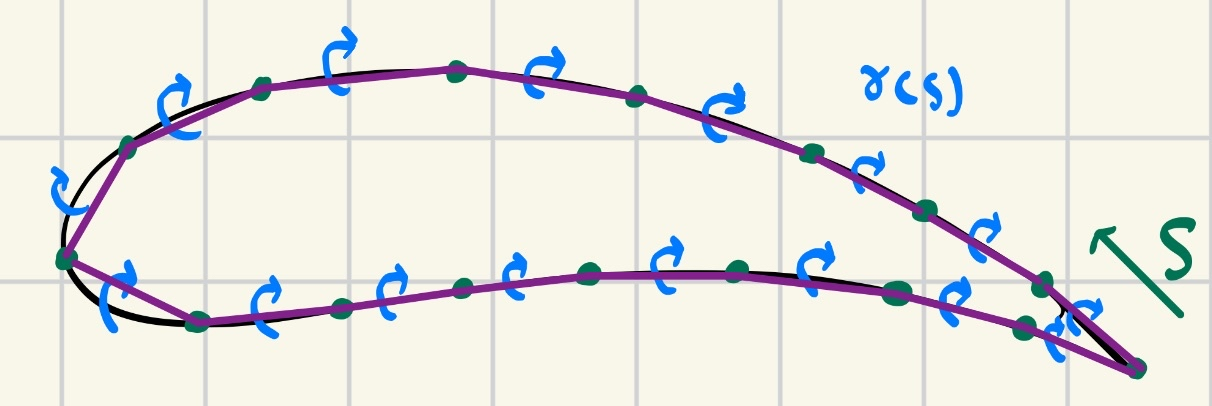
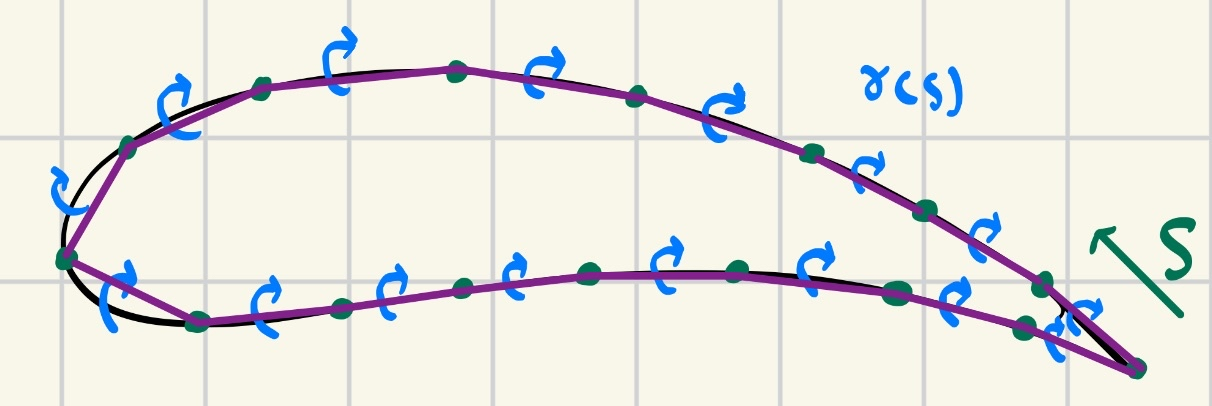

In [17]:
#X_vort = [8, 6.0097, 1.9822, 0, 2.0178, 5.9903, 8]
#X_coll = [7.4658, 4.0047, .5093, .5625, 3.9953, 7.4597]
#Y_vort = [0, .3550, .6124, 0, -.3374, -.1439, 0]
#Y_coll = [.1083, .5784, .3692, -.2710, -.2673, -.0408]


#i = colocation points j=vortex
#create empty matrix for r, u, v, and A
rows = len(X_coll) #panels
cols = len(X_vort) #vortices
r= np.zeros((rows, cols))
u=np.zeros((rows, cols))
v=np.zeros((rows, cols))
A=np.zeros((rows + 1, cols))
n_x=np.zeros(rows)
n_y=np.zeros(rows)

for i in range(rows):
    n_x[i] = np.sin(np.atan2(Y_vort[i+1]-Y_vort[i],X_vort[i+1]-X_vort[i]))   #normal vector X
    n_y[i] = -1 *np.cos(np.atan2(Y_vort[i+1]-Y_vort[i],X_vort[i+1]-X_vort[i]))

for j in range(cols):
    for i in range(rows):
        r[i, j] = np.sqrt((X_coll[i]-X_vort[j])**2+(Y_coll[i]-Y_vort[j])**2)
        u[i,j] = 1 / (2* np.pi * r[i,j] ** 2) * (Y_coll[i] - Y_vort[j])
        v[i,j] = -1 / (2* np.pi * r[i,j] ** 2) * (X_coll[i] - X_vort[j])
        nx = n_x[i] #normal vector X
        ny = n_y[i] #normal vector y
        A[i,j] = u[i,j] * nx + v[i,j] * ny

#Add kutta condition
A[rows, 0] = 1
A[rows, cols - 1] = 1

In [18]:
U_freestream = 1
AOA = 10  #degrees

AOA = AOA * np.pi / 180

V_n_freestream_i = np.zeros(rows)
for i in range(rows):
    V_n_freestream_i[i] = U_freestream * (np.cos(AOA) * n_x[i] + np.sin(AOA) * n_y[i])

V_n_freestream_i = np.append(V_n_freestream_i, 0)
V_n_freestream_i = (-1 * V_n_freestream_i).T

gamma = np.linalg.lstsq(A, V_n_freestream_i, rcond=None)[0] #Solve for Gamma, use least squares because of the singularity created by the over constrained A matrix (because of kutta condition)

Gamma = sum(gamma)
CL = U_freestream * Gamma / .5 /U_freestream**2
print(CL)

1.4231661727496043
